# Introduction

In this workshop, we will go through the steps of training and deploying a model and then training and testing a possible replacement model using the SageMaker Shadow Test feature. We'll do this entirely in code, making use of the <a href="https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/create_inference_experiment.html">SageMaker API</a>. The models will analyze and classify network traffic.  

## Contents

1) [Setup](#setup)
2) [Basic Training](#basic_training)
3) [Register the Models](#register)
4) [Create Endpoint Config](#create_endpoint)
5) [Deploy and Predict](#deploy)
6) [Create a Shadow Test](#shadow)
7) [Evaluate](#eval)

For training our model we will be using datasets <a href="https://registry.opendata.aws/cse-cic-ids2018/">CSE-CIC-IDS2018</a> by CIC and ISCX which are used for security testing and malware prevention.
These datasets include a huge amount of raw network traffic logs, plus pre-processed data where network connections have been reconstructed and  relevant features have been extracted using CICFlowMeter, a tool that outputs network connection features as CSV files. Each record is classified as benign traffic, or it can be malicious traffic, with a total number of 15 classes.

Starting from this featurized dataset, we have executed additional pre-processing for the purpose of this lab:
<ul>
    <li>Encoded class labels</li>
    <li>Replaced invalid string attribute values generated by CICFlowMeter (e.g. inf and Infinity)</li>
    <li>Executed one hot encoding of discrete attributes</li>
    <li>Remove invalid headers logged multiple times in the same CSV file</li>
    <li>Reduced the size of the featurized dataset to ~1.3GB (from ~6.3GB) to speed-up training, while making sure that all classes are well represented</li>
    <li>Executed stratified random split of the dataset into training (80%) and validation (20%) sets</li>
</ul>

Class are represented and have been encoded as follows (train + validation):


| Label                    | Encoded | N. records |
|:-------------------------|:-------:|-----------:|
| Benign                   |    0    |    1000000 |
| Bot                      |    1    |     200000 |
| DoS attacks-GoldenEye    |    2    |      40000 |
| DoS attacks-Slowloris    |    3    |      10000 |
| DDoS attacks-LOIC-HTTP   |    4    |     300000 |
| Infilteration            |    5    |     150000 |
| DDOS attack-LOIC-UDP     |    6    |       1730 |
| DDOS attack-HOIC         |    7    |     300000 |
| Brute Force -Web         |    8    |        611 |
| Brute Force -XSS         |    9    |        230 |
| SQL Injection            |   10    |         87 |
| DoS attacks-SlowHTTPTest |   11    |     100000 |
| DoS attacks-Hulk         |   12    |     250000 |
| FTP-BruteForce           |   13    |     150000 |
| SSH-Bruteforce           |   14    |     150000 |       

The final pre-processed dataset has been saved to a public Amazon S3 bucket for your convenience, and will represent the inputs to the training processes.
<a id='setup'></a>
### Let's get started!

First, we set some variables, including the AWS region we are working in, the IAM (Identity and Access Management) execution role of the notebook instance and the Amazon S3 bucket where we will store data, models, outputs, etc. We will use the Amazon SageMaker default bucket for the selected AWS region, and then define a key prefix to make sure all objects have share the same prefix for easier discoverability.

In [2]:
%pip install jsonlines --quiet
%pip install sagemaker --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
awscli 1.27.103 requires rsa<4.8,>=3.1.2, but you have rsa 4.9 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'status': 'ok', 'restart': True}

In [4]:
import os
import time
import glob
import json
import jsonlines
import base64
import io

import boto3
import sagemaker
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.sklearn.model import SKLearnModel

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output

pd.options.display.max_columns = 100

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker.Session().default_bucket()
prefix = 'shadow-test'
os.environ["AWS_REGION"] = region
sm_client = boto3.Session().client('sagemaker')

print(f'REGION:  {region}')
print(f'ROLE:    {role}')
print(f'BUCKET:  {bucket_name}')

# These are the clasifications that have been encoded as ints, we'll use these for analysis
class_list = ['Benign','Bot','DoS attacks-GoldenEye','DoS attacks-Slowloris','DDoS attacks-LOIC-HTTP','Infilteration','DDOS attack-LOIC-UDP','DDOS attack-HOIC','Brute Force-Web','Brute Force-XSS','SQL Injection','DoS attacks-SlowHTTPTest','DoS attacks-Hulk','FTP-BruteForce','SSH-Bruteforce']

REGION:  us-east-1
ROLE:    arn:aws:iam::431615879134:role/sagemaker-test-role
BUCKET:  sagemaker-us-east-1-431615879134


In [2]:
# clean up
sm_client.delete_model(ModelName =model_name1)
sm_client.delete_model(ModelName =model_name2)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config)
sm_client.delete_endpoint(EndpointName=endpoint_name)

NameError: name 'model_name1' is not defined

In [5]:
sklearn_model = SKLearnModel(model_data="s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/output/hgbc-scikit-2023-03-27-19-04-17-942/output/model.tar.gz",
                             role=role,
                             entry_point="histgradientboost.py",
                             source_dir='./code/',
                             framework_version="1.0-1")

In [6]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_s3 = f's3://{bucket_name}/{prefix}/datacapture_test/'

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=data_capture_s3
)

In [8]:
predictor = sklearn_model.deploy(initial_instance_count=3,instance_type='ml.m5.2xlarge', data_capture_config=data_capture_config)

----!

In [14]:
predictor.endpoint_name

'sagemaker-scikit-learn-2023-04-04-14-39-53-848'

In [9]:
# single prediction
# We expect 4 - DDoS attacks-LOIC-HTTP as the predicted class.
test_values = [80,1056736,3,4,20,964,20,0,6.666666667,11.54700538,964,0,241.0,482.0,931.1691850999999,6.6241710320000005,176122.6667,431204.4454,1056315,2,394,197.0,275.77164469999997,392,2,1056733,352244.3333,609743.1115,1056315,24,0,0,0,0,72,92,2.8389304419999997,3.78524059,0,964,123.0,339.8873763,115523.4286,0,0,1,1,0,0,0,1,1.0,140.5714286,6.666666667,241.0,0.0,0.0,0.0,0.0,0.0,0.0,3,20,4,964,8192,211,1,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0]
result = predictor.predict(np.array(test_values).reshape(1, -1))
print(result)

[4]


In [11]:
from sagemaker import image_uris
model1_uri = 's3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/output/hgbc-scikit-2023-03-27-19-04-17-942/output/model.tar.gz'
model1_ssd = 's3://sagemaker-us-east-1-431615879134/hgbc-scikit-2023-03-27-19-04-17-942/source/sourcedir.tar.gz'# The directory within the container in which the Python script for training is located
model1_script = 'histgradientboost.py'

model2_uri = 's3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/output/rf-scikit-2023-03-27-19-08-18-740/output/model.tar.gz'
model2_ssd = 's3://sagemaker-us-east-1-431615879134/rf-scikit-2023-03-27-19-08-18-740/source/sourcedir.tar.gz'
model2_script = 'randomforest.py'

image_uri = '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3'

model_name1 = "PROD-HGB"
model_name2 = "SHADOW-RF"

print(f"Prod model name: {model_name1}")
print(f"Shadow model name: {model_name2}")

resp = sm_client.create_model(
    ModelName=model_name1,
    ExecutionRoleArn=role,
    PrimaryContainer={
                      "Image": image_uri,
                      "Mode": "SingleModel",
                      "ModelDataUrl": model1_uri,
                      "Environment": {
                          "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
                          "SAGEMAKER_SUBMIT_DIRECTORY": model1_ssd,
                          "SAGEMAKER_PROGRAM": model1_script,
                      },
                     }
)

resp = sm_client.create_model(
    ModelName=model_name2,
    ExecutionRoleArn=role,
    PrimaryContainer={
                      "Image": image_uri,
                      "Mode": "SingleModel",
                      "ModelDataUrl": model2_uri,
                      "Environment": {
                          "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
                          "SAGEMAKER_SUBMIT_DIRECTORY": model2_ssd,
                          "SAGEMAKER_PROGRAM": model2_script,
                      },
                     }
)

Prod model name: PROD-HGB
Shadow model name: SHADOW-RF


In [ ]:
### REMOVE ####

In [144]:
# deploy the endpoint
endpoint_name='shadowtest-endpoint'

# create sagemaker model
print ("create_model API response", create_model_api_response)
print()

endpoint_config='shadowtest-endpoint-config'

# create sagemaker endpoint config
create_endpoint_config_api_response = sm_client.create_endpoint_config(
                                            EndpointConfigName=endpoint_config,
                                            ProductionVariants=[
                                                {
                                                    'VariantName': 'base-variant',
                                                    'ModelName': model_name1,
                                                    'InitialInstanceCount': 3,
                                                    'InstanceType': 'ml.m5.2xlarge',
                                                },
                                            ],
                                            DataCaptureConfig={
                                                'EnableCapture': True,
                                                'InitialSamplingPercentage': 100,
                                                "CaptureOptions": [ 
                                                     { 
                                                        "CaptureMode": "Output"
                                                     }
                                                  ],
                                                'DestinationS3Uri': data_capture_s3
                                            },
                                       )

print ("create_endpoint_config API response", create_endpoint_config_api_response)
print()

# create sagemaker endpoint
create_endpoint_api_response = sm_client.create_endpoint(
                                    EndpointName=endpoint_name,
                                    EndpointConfigName=endpoint_config,
                                )

print ("create_endpoint API response", create_endpoint_api_response)          

create_model API response {'ModelArn': 'arn:aws:sagemaker:us-east-1:278578987671:model/shadow-rf', 'ResponseMetadata': {'RequestId': 'eb1896da-f0a6-44d8-8160-8c63dfff2f54', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'eb1896da-f0a6-44d8-8160-8c63dfff2f54', 'content-type': 'application/x-amz-json-1.1', 'content-length': '71', 'date': 'Wed, 29 Mar 2023 23:17:51 GMT'}, 'RetryAttempts': 0}}

create_endpoint_config API response {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:278578987671:endpoint-config/shadowtest-endpoint-config', 'ResponseMetadata': {'RequestId': '96003544-7d78-47d7-aceb-b53e3bcf4103', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '96003544-7d78-47d7-aceb-b53e3bcf4103', 'content-type': 'application/x-amz-json-1.1', 'content-length': '107', 'date': 'Mon, 03 Apr 2023 20:02:21 GMT'}, 'RetryAttempts': 0}}

create_endpoint API response {'EndpointArn': 'arn:aws:sagemaker:us-east-1:278578987671:endpoint/shadowtest-endpoint', 'ResponseMetadata': {'R

In [145]:
sm_client.describe_endpoint(EndpointName = endpoint_name)

{'EndpointName': 'shadowtest-endpoint',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:278578987671:endpoint/shadowtest-endpoint',
 'EndpointConfigName': 'shadowtest-endpoint-config',
 'DataCaptureConfig': {'EnableCapture': True,
  'CaptureStatus': 'Started',
  'CurrentSamplingPercentage': 100,
  'DestinationS3Uri': 's3://sagemaker-us-east-1-278578987671/shadow-test/datacapture_test/'},
 'EndpointStatus': 'Creating',
 'CreationTime': datetime.datetime(2023, 4, 3, 20, 2, 21, 964000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 4, 3, 20, 2, 22, 264000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '30170138-adf2-443b-be75-e2d81ab4f943',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '30170138-adf2-443b-be75-e2d81ab4f943',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '460',
   'date': 'Mon, 03 Apr 2023 20:02:24 GMT'},
  'RetryAttempts': 0}}

In [146]:
from time import sleep
def wait_until_endpoint_started(endpoint_name):
    print(f'Waiting on endpoint: {endpoint_name}')
    done = False
    while not done:
        description = sm_client.describe_endpoint(EndpointName=endpoint_name)
        status = description["EndpointStatus"].lower()
        print(f'Status: {status}')
        if status == 'failed' or status == 'cancelled':
            print("Failure detected. Exiting Loop.")
            print(shadowtestdescribe)
            return
        elif status == 'inservice':
            print("endpoint is running! Exiting Loop.")
            return
        sleep(60)

In [147]:
wait_until_endpoint_started(endpoint_name)

Waiting on endpoint: shadowtest-endpoint
Status: creating
Status: creating
Status: creating
Status: inservice
endpoint is running! Exiting Loop.


<a id='shadow'></a>
# Create a Shadow Test 

## Create a Shadow Test using an Existing Endpoint

Now we will create a shadow test using the existing production endpoint.  We will pass the validation data we set aside earlier to the endpoint during this test and stop this test using the API later in the notebook.  Note that we could also specify the test start and stop time when we create the inference experiements.  If we don't provide the start and end times, then the experiment starts immediately and concludes after 7 days.  We are using an existing production endpoint for this test.  SageMaker will update that endpoint with the new model variants.  The production endpoint will also update the inference compute instance type for the production variant if needed. 


In [140]:
sm_client.delete_inference_experiment(Name=shadowtestname)

{'InferenceExperimentArn': 'arn:aws:sagemaker:us-east-1:278578987671:inference-experiment/shadowinferencetestexistingep',
 'ResponseMetadata': {'RequestId': '8e43f528-5750-4316-98c2-03b71e4cae2b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8e43f528-5750-4316-98c2-03b71e4cae2b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '120',
   'date': 'Mon, 03 Apr 2023 20:01:50 GMT'},
  'RetryAttempts': 0}}

In [12]:
#image_uris.retrieve(framework='sklearn',region='us-east-1',version='0.23-1',image_scope='inference')
data_capture_s3 = f's3://{bucket_name}/{prefix}/datacapture_test/'

In [15]:
shadowtestname = 'ShadowInferenceTestExistingEP'
infexperimentarn = sm_client.create_inference_experiment(
    Name=shadowtestname,
    Type='ShadowMode',
    Description='Shadow inference test created via boto3 python API using an existing EP',
    RoleArn=role,
    EndpointName=predictor.endpoint_name,
    ModelVariants=[
        {
            'ModelName': model_name1,
            'VariantName': 'AllTraffic',
            'InfrastructureConfig': {
                'InfrastructureType':'RealTimeInference',
                'RealTimeInferenceConfig': {
                    'InstanceType': 'ml.m5.2xlarge',
                    'InstanceCount': 3 
                }
            }
        },
        
        {
            'ModelName': model_name2,
            'VariantName': 'Shadow-01',
            'InfrastructureConfig': {
                'InfrastructureType':'RealTimeInference',
                'RealTimeInferenceConfig': {
                    'InstanceType': 'ml.m5.2xlarge',
                    'InstanceCount': 3 
                }
            }
        },
    ],
    DataStorageConfig={
        'Destination':data_capture_s3,
    },
    ShadowModeConfig={
        'SourceModelVariantName': 'AllTraffic',
        'ShadowModelVariants': [
            {
                'ShadowModelVariantName': 'Shadow-01',
                'SamplingPercentage': 100
            },
        ]
    },
)   


In [16]:
shadowtestdescribe = sm_client.describe_inference_experiment(Name=shadowtestname)
shadowtestdescribe

{'Arn': 'arn:aws:sagemaker:us-east-1:431615879134:inference-experiment/shadowinferencetestexistingep',
 'Name': 'ShadowInferenceTestExistingEP',
 'Type': 'ShadowMode',
 'Schedule': {'StartTime': datetime.datetime(2023, 4, 4, 15, 0, 54, 488000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2023, 4, 11, 15, 0, 54, 488000, tzinfo=tzlocal())},
 'Status': 'Creating',
 'Description': 'Shadow inference test created via boto3 python API using an existing EP',
 'CreationTime': datetime.datetime(2023, 4, 4, 15, 0, 53, 903000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 4, 4, 15, 0, 54, 465000, tzinfo=tzlocal()),
 'RoleArn': 'arn:aws:iam::431615879134:role/sagemaker-test-role',
 'EndpointMetadata': {'EndpointName': 'sagemaker-scikit-learn-2023-04-04-14-39-53-848'},
 'ModelVariants': [{'ModelName': 'PROD-HGB',
   'VariantName': 'AllTraffic',
   'InfrastructureConfig': {'InfrastructureType': 'RealTimeInference',
    'RealTimeInferenceConfig': {'InstanceType': 'ml.m5.2xlarge'

In [17]:
from time import sleep
def wait_until_test_complete(test_name):
    print(f'Waiting on shadow test: {test_name}')
    done = False
    while not done:
        shadowtestdescribe = sm_client.describe_inference_experiment(Name=shadowtestname)
        status = shadowtestdescribe["Status"].lower()
        print(f'Status: {status}')
        if status == 'failed' or status == 'cancelled':
            print("Failure detected. Exiting Loop.")
            print(shadowtestdescribe)
            return
        elif shadowtestdescribe["Status"].lower() == 'running':
            print("Shadow test is running! Exiting Loop.")
            return
        sleep(60)

In [ ]:
wait_until_test_complete(shadowtestname)

Waiting on shadow test: ShadowInferenceTestExistingEP
Status: creating
Status: creating
Status: creating
Status: creating
Status: running
Shadow test is running! Exiting Loop.


## Simulate Production Traffic

We will now simulate the production traffic.  We will loop over the production data.  In a real production use case you won't need to do this since actual production data will be flowing to the production endpoint.  Since our shadow test is now active the production variant and the shadow variant will recieve the inference input.  Only the production output will be supplied in the response, however, since we have configured the test to capture data we will record both the production and shadow variant responses in s3.  


In [19]:
holdout = pd.read_csv('./data/holdout.csv')

In [21]:
%%time 
# this should take ~ 2 minutes to complete
indexes = []
actuals = []
i = 0
for index, row in holdout.iterrows():
    vals = row.to_numpy()
    #prediction = runtimeclient.invoke_endpoint(EndpointName=endpoint_name, ContentType='text/csv', Body=vals)
    prediction = predictor.predict(vals[1::].reshape(1, -1),inference_id=f'shadow test, index {index}')
    actuals.append(vals[0])
    indexes.append(index)
    
    i+=1
    if i%1000 == 0:
        print(i)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
CPU times: user 30.5 s, sys: 957 ms, total: 31.5 s
Wall time: 2min 28s


In [23]:
storage = shadowtestdescribe['DataStorageConfig']['Destination']+predictor.endpoint_name +'/'
storage

's3://sagemaker-us-east-1-431615879134/shadow-test/datacapture_test/sagemaker-scikit-learn-2023-04-04-14-39-53-848/'

In [24]:
!aws s3 ls {storage}

                           PRE AllTraffic/
                           PRE Shadow-01/


In [25]:
!aws s3 cp {storage} ./data/datacapture/  --recursive

download: s3://sagemaker-us-east-1-431615879134/shadow-test/datacapture_test/sagemaker-scikit-learn-2023-04-04-14-39-53-848/AllTraffic/2023/04/04/14/49-34-322-762a1967-5bd7-4280-8bac-1f43e4c8f9d2.jsonl to data/datacapture/AllTraffic/2023/04/04/14/49-34-322-762a1967-5bd7-4280-8bac-1f43e4c8f9d2.jsonl
download: s3://sagemaker-us-east-1-431615879134/shadow-test/datacapture_test/sagemaker-scikit-learn-2023-04-04-14-39-53-848/AllTraffic/2023/04/04/15/06-52-993-c6976a00-7ad6-45b7-b670-bd25b25ded56.jsonl to data/datacapture/AllTraffic/2023/04/04/15/06-52-993-c6976a00-7ad6-45b7-b670-bd25b25ded56.jsonl
download: s3://sagemaker-us-east-1-431615879134/shadow-test/datacapture_test/sagemaker-scikit-learn-2023-04-04-14-39-53-848/AllTraffic/2023/04/04/15/06-52-743-7862a9a9-934c-4ae4-9a55-ea620e9f6b8b.jsonl to data/datacapture/AllTraffic/2023/04/04/15/06-52-743-7862a9a9-934c-4ae4-9a55-ea620e9f6b8b.jsonl
download: s3://sagemaker-us-east-1-431615879134/shadow-test/datacapture_test/sagemaker-scikit-learn-

In [26]:
shadowfiles = glob.glob('./data/datacapture/Shadow-01/**/*.jsonl',recursive=True)
prodfiles = glob.glob('./data/datacapture/AllTraffic/**/*.jsonl',recursive=True)

In [27]:
shadowin = []
shadowout = []
shadowid = []

for f in shadowfiles:
    print(f)
    with jsonlines.open(f) as reader:
        for obj in reader:
            
            try:
                infid = obj['eventMetadata']['inferenceId'].split(' ')
                shadowid.append(int(infid[-1]))

                # input to model
                model_input = base64.b64decode(obj['captureData']['endpointInput']['data'])
                shadowin.append(np.load(io.BytesIO(model_input))[0].tolist())

                # output from model
                model_output = base64.b64decode(obj['captureData']['endpointOutput']['data'])
                shadowout.append(np.load(io.BytesIO(model_output))[0])
            except:
                pass       

./data/datacapture/Shadow-01/2023/04/04/15/07-52-838-0995e34f-55a6-42a5-a92c-54d0b5d63495.jsonl
./data/datacapture/Shadow-01/2023/04/04/15/07-52-977-fdc4acd9-1ddc-4cbe-a5d3-3f02d8b6441a.jsonl
./data/datacapture/Shadow-01/2023/04/04/15/06-52-747-f439c331-ebfb-45e2-9775-760c301520e5.jsonl
./data/datacapture/Shadow-01/2023/04/04/15/07-52-828-13fa6544-f3b9-4377-8320-7b4c8030cc82.jsonl
./data/datacapture/Shadow-01/2023/04/04/15/06-52-805-52c1d0d9-6146-4056-bdd6-9103038f22b0.jsonl
./data/datacapture/Shadow-01/2023/04/04/15/06-52-961-8884a64a-f21d-4c85-b69d-5f65d75fc4b4.jsonl
./data/datacapture/Shadow-01/2023/03/22/15/05-21-479-2af78f0c-a66b-44d8-92f2-e4a751e18fa2.jsonl
./data/datacapture/Shadow-01/2023/03/22/15/04-21-333-b0834788-eb98-4175-8e24-ffa96c1b1d15.jsonl
./data/datacapture/Shadow-01/2023/03/22/15/06-21-556-5c87991d-857c-4467-b42a-7d2fe6285705.jsonl
./data/datacapture/Shadow-01/2023/03/22/15/04-21-234-9d82843a-ea1b-4e3e-984a-fa998e720e1a.jsonl
./data/datacapture/Shadow-01/2023/03/22/

In [28]:
shadowdf = pd.DataFrame(data=shadowout,index=shadowid,columns=['Shadow'])
shadowdf

,Shadow
4081,0
4086,4
4091,4
4092,0
4103,0
...,...
503610,12
281391,12
404076,0
125421,14


In [29]:
shadowdf['Shadow'] = pd.to_numeric(shadowdf['Shadow'])
shadowdf['Shadow'] = shadowdf['Shadow'].astype(int)
shadowdf = pd.merge(shadowdf,holdout['Target'],left_index=True,right_index=True)
acc = accuracy_score(shadowdf['Target'],shadowdf['Shadow'])
wf1 = f1_score(shadowdf['Target'],shadowdf['Shadow'],average='weighted')
print(acc, wf1)

0.94676291450485 0.9474719184515465


In [30]:
print(classification_report(shadowdf['Target'],shadowdf['Shadow']))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      3347
           1       0.96      0.97      0.96       650
           2       0.97      0.96      0.97       132
           3       0.94      1.00      0.97        34
           4       0.97      0.95      0.96      1008
           5       0.74      0.89      0.81       507
           6       1.00      1.00      1.00         5
           7       0.96      0.97      0.96       985
           8       1.00      0.33      0.50         3
           9       1.00      1.00      1.00         1
          11       0.97      0.96      0.96       332
          12       0.96      0.95      0.96       858
          13       0.96      0.97      0.97       503
          14       0.96      0.96      0.96       501

    accuracy                           0.95      8866
   macro avg       0.95      0.92      0.92      8866
weighted avg       0.95      0.95      0.95      8866



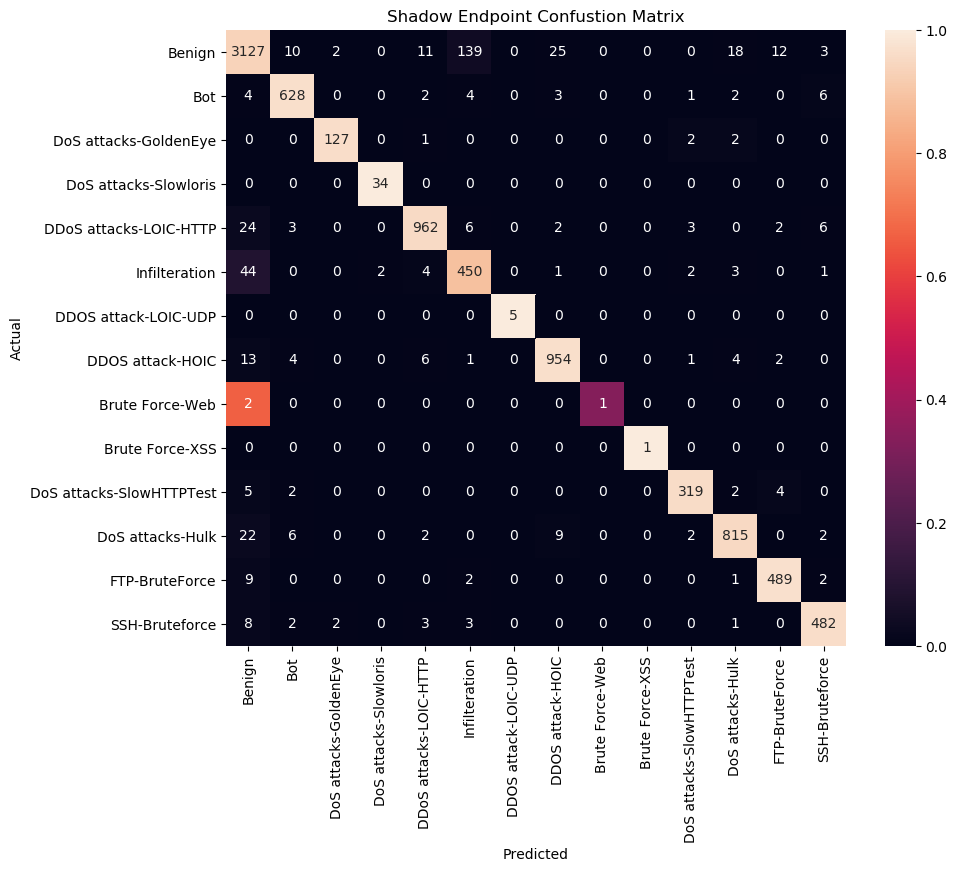

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(shadowdf['Target'],shadowdf['Shadow'])
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
clist = [class_list[i] for i in np.sort(shadowdf['Target'].unique())]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='',xticklabels=clist,yticklabels=clist)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Shadow Endpoint Confustion Matrix')
plt.show()

In [32]:
%%time

prodin = []
prodout = []
prodid = []

for f in prodfiles:
    print(f)
    with jsonlines.open(f) as reader:
        for obj in reader:
            try:               
                infid = obj['eventMetadata']['inferenceId'].split(' ')
                prodid.append(int(infid[-1]))

                # input to model
                model_input = base64.b64decode(obj['captureData']['endpointInput']['data'])
                prodin.append(np.load(io.BytesIO(model_input))[0].tolist())

                # output from model
                model_output = base64.b64decode(obj['captureData']['endpointOutput']['data'])
                prodout.append(np.load(io.BytesIO(model_output))[0])
                
            except:
                pass

./data/datacapture/AllTraffic/2023/04/04/15/07-53-060-117bad46-6c6c-4adf-891d-f309c799fca5.jsonl
./data/datacapture/AllTraffic/2023/04/04/15/06-52-993-c6976a00-7ad6-45b7-b670-bd25b25ded56.jsonl
./data/datacapture/AllTraffic/2023/04/04/15/06-52-743-7862a9a9-934c-4ae4-9a55-ea620e9f6b8b.jsonl
./data/datacapture/AllTraffic/2023/04/04/15/06-52-846-465218f3-c113-49e6-810d-cb9f6f5fbd99.jsonl
./data/datacapture/AllTraffic/2023/04/04/15/07-52-873-69300b0b-2c95-4b02-8867-c14a1deebc1b.jsonl
./data/datacapture/AllTraffic/2023/04/04/15/07-52-767-0fa4a321-7bec-4708-8811-ea65ad46160c.jsonl
./data/datacapture/AllTraffic/2023/04/04/14/49-34-322-762a1967-5bd7-4280-8bac-1f43e4c8f9d2.jsonl
./data/datacapture/AllTraffic/2023/03/22/15/04-21-297-d52405c6-0616-4b70-b91f-1fc3b0eb4ce1.jsonl
./data/datacapture/AllTraffic/2023/03/22/15/04-21-511-8ea860c1-e4ba-4659-9685-124f7372951f.jsonl
./data/datacapture/AllTraffic/2023/03/22/15/06-21-634-6865e28d-a77d-45fb-8a42-70eeccc24688.jsonl
./data/datacapture/AllTraffic/

In [33]:
proddf = pd.DataFrame(data=prodout,index=prodid,columns=['Prod'])
proddf

,Prod
4095,5
4098,4
4099,7
4101,12
4104,14
...,...
19501,4
59506,13
473887,0
417321,7


In [34]:
# Line up our production model predictions with the true value based on the index
proddf = pd.merge(proddf,holdout['Target'],left_index=True,right_index=True)

In [35]:
acc = accuracy_score(proddf['Target'],proddf['Prod'])
wf1 = f1_score(proddf['Target'],proddf['Prod'],average='weighted')
print(acc, wf1)

0.9447997307303938 0.9464897087343956


In [36]:
print(classification_report(proddf['Target'],proddf['Prod']))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3369
           1       0.96      0.97      0.96       653
           2       0.97      0.96      0.97       132
           3       0.94      1.00      0.97        34
           4       0.97      0.95      0.96      1010
           5       0.72      0.91      0.81       512
           6       0.83      1.00      0.91         5
           7       0.96      0.97      0.96       990
           8       0.50      0.33      0.40         3
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.97      0.96      0.97       332
          12       0.96      0.95      0.96       863
          13       0.96      0.97      0.97       505
          14       0.96      0.96      0.96       504

    accuracy                           0.94      8913
   macro avg       0.78      0.79      0.78      8913
weighted avg       0.95   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


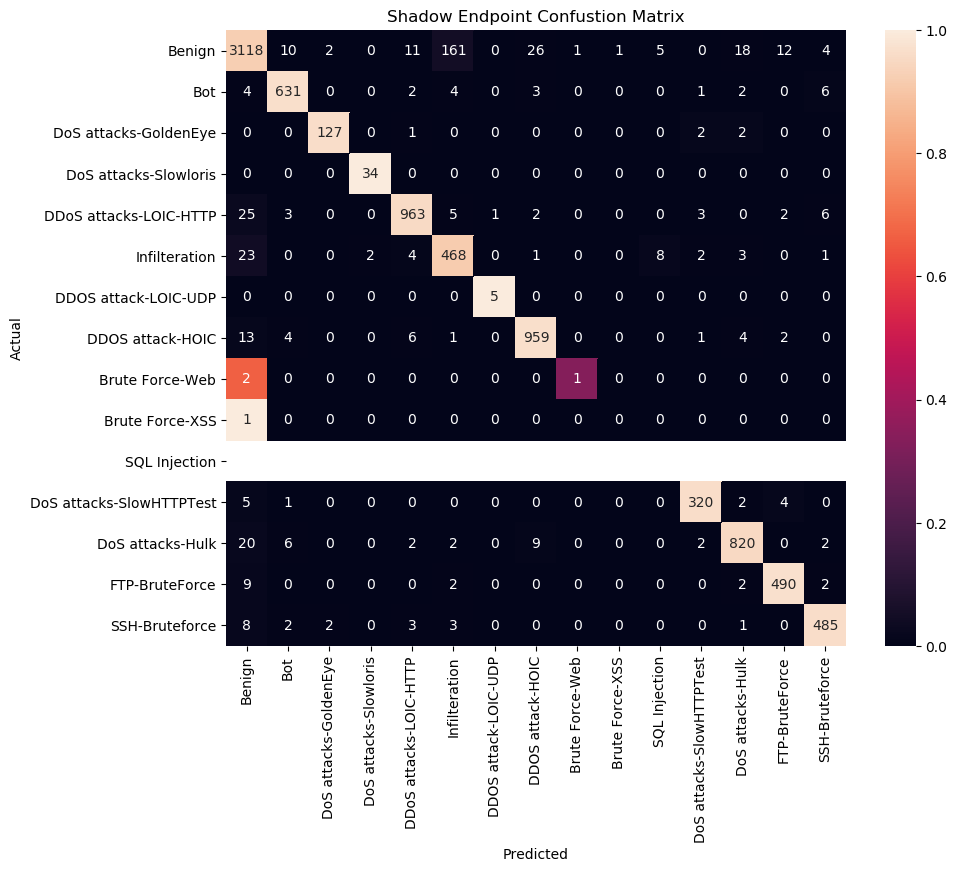

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(proddf['Target'],proddf['Prod'])
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='',xticklabels=class_list,yticklabels=class_list)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Shadow Endpoint Confustion Matrix')
plt.show()

In [40]:
sm_client.stop_inference_experiment(
    Name=shadowtestname,
    ModelVariantActions={
        'Shadow-01': 'Promote',
        'AllTraffic': 'Remove'
    },
    DesiredState='Completed',
    Reason='Shadow variant performed better in validation'
)

ClientError: An error occurred (ValidationException) when calling the StopInferenceExperiment operation: Cannot stop InferenceExperiment in Stopping status

In [41]:
# Here we show that the shadow model is now deployed to production
sm_client.describe_endpoint(EndpointName = predictor.endpoint_name)

{'EndpointName': 'sagemaker-scikit-learn-2023-04-04-14-39-53-848',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:431615879134:endpoint/sagemaker-scikit-learn-2023-04-04-14-39-53-848',
 'EndpointConfigName': 'ShadowInferenceT-EpConfig-DvfkZskPFIuSaZGw',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn@sha256:5867d612f7c449d136e6cd7b3a88958bc7754e07290fbd34947a6375c15febb9',
     'ResolutionTime': datetime.datetime(2023, 4, 4, 15, 1, 13, 114000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'DataCaptureConfig': {'EnableCapture': True,
  'CaptureStatus': 'Started',
  'CurrentSamplingPercentage': 100,
  'DestinationS3Uri': 's3://sagemaker-us-east-1-431615879134/shadow-test/datacapture_t

## Clean Up

In [42]:
def wait_until_complete(test_name):
    print(f'Waiting on shadow test: {test_name}')
    done = False
    while not done:
        shadowtestdescribe = sm_client.describe_inference_experiment(Name=shadowtestname)
        status = shadowtestdescribe["Status"].lower()
        print(f'Status: {status}')
        if status == "completed":
            print("Shadow test is stopped, ok to delete. Exiting Loop.")
            return
        sleep(60)

In [43]:
wait_until_complete(shadowtestname)

Waiting on shadow test: ShadowInferenceTestExistingEP
Status: stopping
Status: stopping
Status: stopping
Status: completed
Shadow test is stopped, ok to delete. Exiting Loop.


In [44]:
#predictor.delete_endpoint()
sm_client.delete_inference_experiment(
    Name=shadowtestname
)
sm_client.delete_endpoint(EndpointName=predictor.endpoint_name)

{'ResponseMetadata': {'RequestId': 'f3b721c8-1c58-45d7-8869-822f7da62a79',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f3b721c8-1c58-45d7-8869-822f7da62a79',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 04 Apr 2023 15:16:22 GMT'},
  'RetryAttempts': 0}}

# References

* A Realistic Cyber Defense Dataset (CSE-CIC-IDS2018) - https://registry.opendata.aws/cse-cic-ids2018/
* AIM362 - Re:Invent 2019 SageMaker Debugger and Model Monitor - https://github.com/aws-samples/reinvent2019-aim362-sagemaker-debugger-model-monitor